In [1]:
%%html
<style>
.container{width: 100%}
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings 
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import os
os.sys.path.insert(0, "../")

### Load Data

In [6]:
from tools import load_cancer
data, desc = load_cancer("../data_base")

In [7]:
print(desc)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [8]:
data = data.rename(columns = {"target": "WDBC"})
data["WDBC"] = np.where(data.WDBC==1., 0., 1.)
features = data.drop("WDBC", axis = 1)
target = data.WDBC

### EDA

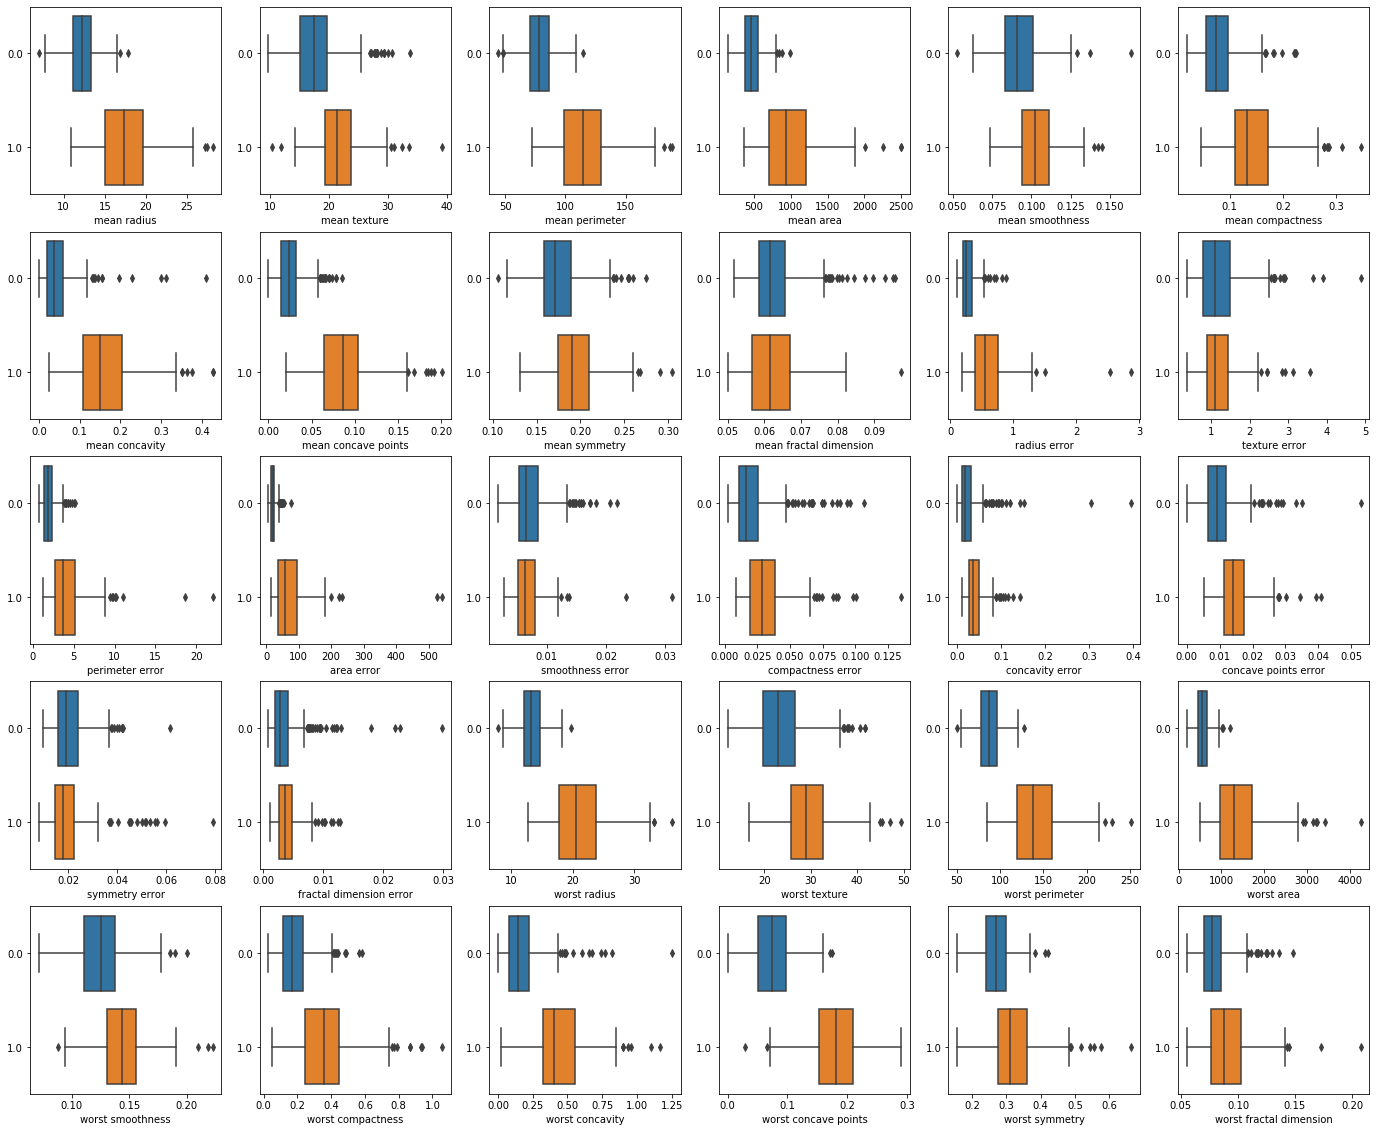

In [9]:
import seaborn as sns

fig, axes = plt.subplots(5, 6, figsize = (24, 20))
for i in range(5):
    for j in range(6):
        col_num = i * 6 + j
        ax = axes[i, j]
        # ax.scatter(data.iloc[:, col_num], data.WDBC)
        # ax.set_title(f"{data.columns[col_num]}")
        sns.boxplot(x = data.columns[col_num], y = "WDBC", ax = ax, data = data, orient = "h")
        ax.set_ylabel("")

### Feature Engineering

#### Winsorize

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target.rename("target"), test_size = .3, random_state = 42)

In [11]:
# features[features < features.quantile(.1)] = np.tile(features.quantile(.1).values[None, :], (features.shape[0], 1))
# features[features < features.quantile(.9)] = np.tile(features.quantile(.9).values[None, :], (features.shape[0], 1))

In [12]:
mean = X_train.mean()
std = X_train.std()
f = lambda X_train: (X_train - mean) / std
X_train, X_test = f(X_train), f(X_test)

### Make a Model

#### Logistic GLM - GAM

In [58]:
from glm_gam import GlmGam

smooth_names = X_train.columns[:10]
df = 4
degree = 3
dfs = [df] * len(smooth_names)
alphas = [1e03] * len(smooth_names)
X = pd.concat([X_train, X_test], axis = 0)
mod = GlmGam(smooth_names, dfs, alphas, degree = degree, 
             lower_bound = X[smooth_names].min().values, 
             upper_bound = X[smooth_names].max().values)

In [59]:
res = mod.fit(X_train, y_train)

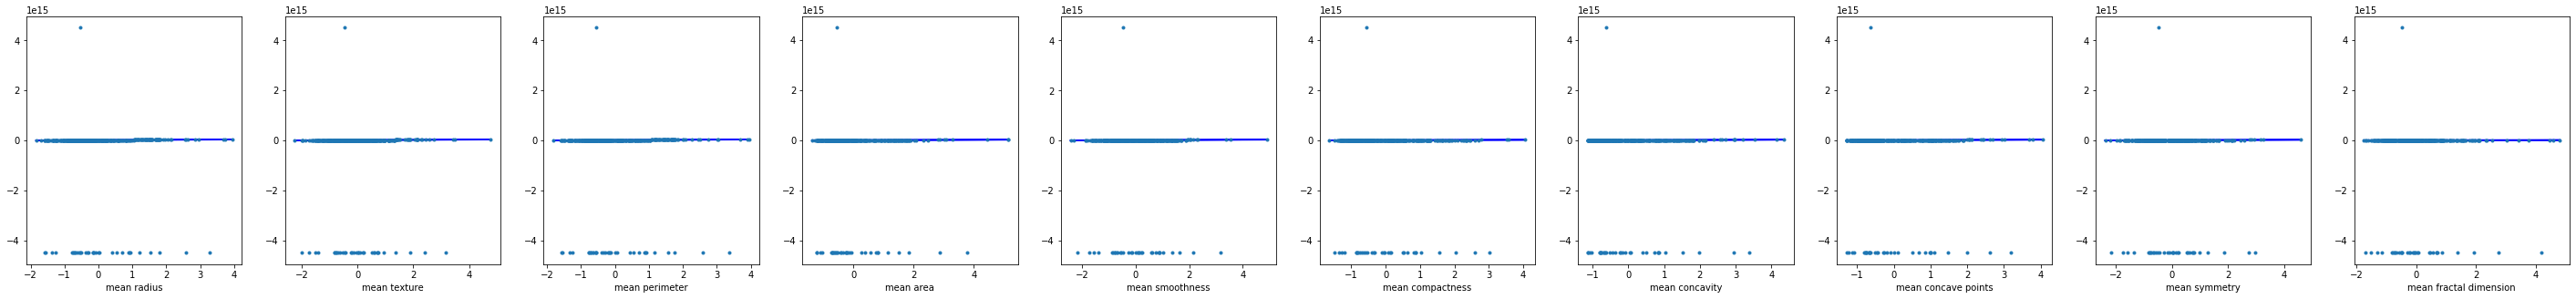

In [60]:
_ = res.plot_partial(include_constant = True)

##### Performance
Accuracy

In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.where(y_test>.5, 1., 0.))

1.0

AUC

In [17]:
y_test_hat = res.predict(X_test)

In [18]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat, pos_label = 1.0)
auc(fpr, tpr)

0.9345238095238094

ROC - AUC

In [19]:
from glm_gam import GlmGam

smooth_names = ["fractal dimension error", "perimeter error", "area error"]

df = 5
dfs = [df] * len(smooth_names)
alphas = [1e6] * len(smooth_names)
mod = GlmGam(smooth_names, dfs, alphas)

In [20]:
from visualizations import plot_roc_curve
X, y = pd.concat([X_train, X_test], axis = 0), pd.concat([y_train, y_test], axis = 0)
mod.lower_bound = X.min()[mod.smooth_names].values
mod.upper_bound = X.max()[mod.smooth_names].values
plot_roc_curve(mod, X, y, cv = 6, n_jobs = 2)

PerfectSeparationError: Perfect separation detected, results not available